In [1]:
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.differentiator.advection import Advection
from PARCtorch.differentiator.diffusion import Diffusion
from PARCtorch.differentiator.differentiator import Differentiator
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.differentiator.mappingandrecon import MappingAndRecon
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.poisson import Poisson
from PARCtorch.integrator.rk4 import RK4
from PARCtorch.utilities.unet import UNet
from PARCtorch.differentiator.advection import AdvectionUpwind

In [2]:
import torch
from torchmetrics.functional.image import image_gradients
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from torchview import draw_graph

### Finite difference testing

In [ ]:
image = torch.arange(0, 1 * 1 * 5 * 5, dtype=torch.float32).to("cuda")
image = torch.reshape(image, (1, 1, 5, 5))
dy, dx = image_gradients(image)
dy[0, 0, :, :]

In [ ]:
dx[0, 0, :, :]

In [ ]:
right_diff = FiniteDifference(padding_mode="replicate")
dy, dx = right_diff(image)
dy[0, 0, :, :]

In [ ]:
dx[0, 0, :, :]

In [ ]:
summary(right_diff, (8, 1, 5, 5))

### Advection testing

In [ ]:
adv = Advection(right_diff)

In [ ]:
data = np.load(
    "/project/vil_baek/data/physics/transport_eqn_square/transport_eqn_square_64_1.00_8.00_8.00_1.00_2.00_8.00_120_0.10.npy"
)
adv_gt = (data[1, :, :, 0] - data[0, :, :, 0]) / 0.1

In [ ]:
state_var = torch.permute(
    torch.tensor(data[0:1, :, :, 0:1], dtype=torch.float32), (0, 3, 1, 2)
).cuda()
vel_var = torch.permute(
    torch.tensor(data[0:1, :, :, 1:], dtype=torch.float32), (0, 3, 1, 2)
).cuda()
adv_parc = adv(state_var, vel_var)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
im0 = ax0.imshow(adv_parc.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
plt.colorbar(im0)
im1 = ax1.imshow(-adv_gt)
ax1.set_title("GT")
plt.colorbar(im1)

In [ ]:
summary(adv, [(8, 1, 64, 128), (8, 2, 64, 128)])

### Diffusion testing

In [ ]:
x, y = np.linspace(-1.0, 1.0, 64), np.linspace(-1.0, 1.0, 64)
xx, yy = np.meshgrid(x, y, indexing="xy")
data = (xx**2.0) * (yy**3.0)
lap_gt = 2.0 * (yy**3.0) + (xx**2.0) * (6.0 * yy)

In [ ]:
dif = Diffusion(right_diff)
lap_parc = dif(
    torch.tensor(
        data.reshape(1, 1, 64, 64), dtype=torch.float32, device="cuda"
    )
)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
im0 = ax0.imshow(
    lap_parc.detach().cpu().numpy()[0, 0, :, :] * 32 * 32, vmin=-8.0, vmax=8.0
)
ax0.set_title("PARC")
plt.colorbar(im0)
im1 = ax1.imshow(lap_gt)
ax1.set_title("GT")
plt.colorbar(im1)

### Poisson testing

In [ ]:
x, y = np.linspace(-1.0, 1.0, 64), np.linspace(-1.0, 1.0, 64)
xx, yy = np.meshgrid(x, y, indexing="xy")
vec_x = (xx**2.0) * (yy**3.0)
vec_y = (xx**4.0) * (yy**5.0)
vec = torch.cat(
    [
        torch.tensor(vec_x.reshape(1, 1, 64, 64), dtype=torch.float),
        torch.tensor(vec_y.reshape(1, 1, 64, 64), dtype=torch.float),
    ],
    1,
)
x_dx, x_dy = 2.0 * xx * (yy**3.0), (xx**2.0) * 3.0 * (yy**2.0)
y_dx, y_dy = 4.0 * (xx**3.0) * (yy**5.0), (xx**4.0) * 5.0 * (yy * 4.0)

In [ ]:
poi = Poisson(right_diff)
x_dx2, y_dy2, x_dxy_dy = poi(vec.cuda())

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(x_dx2.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
ax1.imshow(x_dx * x_dx)
ax1.set_title("GT")

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(y_dy2.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
ax1.imshow(y_dy * y_dy)
ax1.set_title("GT")

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.imshow(x_dxy_dy.detach().cpu().numpy()[0, 0, :, :])
ax0.set_title("PARC")
ax1.imshow(x_dx * y_dy)
ax1.set_title("GT")

### SPADE

In [ ]:
from PARCtorch.utilities.spade import SPADE


spade = SPADE(64, 2).cuda()
draw_graph(
    spade, input_size=[(8, 64, 128, 256), (8, 2, 128, 256)]
).visual_graph.render("SPADE", directory="../docs", format="png")
summary(spade, [(8, 64, 128, 256), (8, 2, 128, 256)])

### Spade generator unit

In [ ]:
from PARCtorch.utilities.spade import SPADEGeneratorUnit

sgu = SPADEGeneratorUnit(64, 64, 2).cuda()
input_fe, input_explicit, input_rand = (
    torch.randn(8, 64, 128, 256).cuda(),
    torch.randn(8, 2, 128, 256).cuda(),
    True,
)
draw_graph(
    sgu, [input_fe, input_explicit, input_rand], depth=1
).visual_graph.render("SPADEGeneratorUnit", directory="../docs", format="png")
summary(sgu, input_data=[input_fe, input_explicit, input_rand])

### UNetUpBlock

In [ ]:
from PARCtorch.utilities.unet import UNetUpBlock

uup = UNetUpBlock(64, 32, use_concat=False).cuda()
draw_graph(
    uup, input_size=[(8, 64, 16, 32), (8, 64, 32, 64)]
).visual_graph.render("UNetUpBlock_nocat", directory="./doc", format="png")
summary(uup, input_size=[(8, 64, 16, 32), (8, 64, 32, 64)])

In [ ]:
uup = UNetUpBlock(64, 32, skip_channels=64, use_concat=True).cuda()
draw_graph(
    uup, input_size=[(8, 64, 16, 32), (8, 64, 32, 64)]
).visual_graph.render("UNetUpBlock_cat", directory="../docs", format="png")
summary(uup, input_size=[(8, 64, 16, 32), (8, 64, 32, 64)])

### UNetDownBlock

In [ ]:
from PARCtorch.utilities.unet import UNetDownBlock

udown = UNetDownBlock(64, 128)
draw_graph(udown, input_size=(8, 64, 128, 256)).visual_graph.render(
    "UNetDownBlock", directory="../docs", format="png"
)
summary(udown, input_size=(8, 64, 128, 256))

### UNet

In [ ]:
unet = UNet(
    [64, 64 * 2, 64 * 4, 64 * 8, 64 * 16],
    5,
    128,
    up_block_use_concat=[False, True, False, True],
    skip_connection_indices=[2, 0],
)
draw_graph(unet, input_size=(8, 5, 128, 192), depth=1).visual_graph.render(
    "UNet_em", directory="../docs", format="png"
)
summary(unet, input_size=(8, 5, 128, 192))

In [ ]:
unet = UNet(
    [64, 64 * 2, 64 * 4],
    5,
    64,
    up_block_use_concat=[False, True],
    skip_connection_indices=[0],
)
draw_graph(unet, input_size=(8, 5, 128, 192), depth=1).visual_graph.render(
    "UNet_burger", directory="../docs", format="png"
)
summary(unet, input_size=(8, 5, 128, 192))

### Resnet Block

In [ ]:
from PARCtorch.utilities.resnet import ResNetBlock

resnet_block = ResNetBlock(64, 64, 3, "constant")
draw_graph(resnet_block, input_size=(8, 64, 128, 256)).visual_graph.render(
    "ResNetBlock", directory="../docs", format="png"
)
summary(resnet_block, input_size=(8, 64, 128, 256))

### Resnet

In [ ]:
from PARCtorch.utilities.resnet import ResNet


resnet = ResNet(32, [128, 128], 1, False)
draw_graph(resnet, input_size=(8, 32, 128, 256), depth=2).visual_graph.render(
    "ResNet", directory="../docs", format="png"
)
summary(resnet, input_size=(8, 32, 128, 256))

In [ ]:
resnet = ResNet(32, [64, 128, 256], 3, True)
draw_graph(resnet, input_size=(8, 32, 128, 256), depth=2).visual_graph.render(
    "ResNet_down", directory="../docs", format="png"
)

### Mapping And Recon

In [ ]:
mar = MappingAndRecon(128, 2, 1, "constant")
draw_graph(
    mar, input_size=[(8, 128, 128, 192), (8, 2, 128, 192)]
).visual_graph.render("MappingAndRecon_2_2", directory="../docs", format="png")
summary(mar, input_size=[(8, 128, 128, 192), (8, 2, 128, 192)])

### Differentiator

In [ ]:
# EM: T, p, mu, u, v
# Adv: all vars
# Dif: T only
n_fe_features = 128
unet_em = UNet(
    [64, 64 * 2, 64 * 4, 64 * 8, 64 * 16],
    5,
    n_fe_features,
    up_block_use_concat=[False, True, False, True],
    skip_connection_indices=[2, 0],
).cuda()
diff_em = Differentiator(
    3,  # 3 state variables: T, p, mu. We always assume 2 velocity being the last 2 channels
    n_fe_features,  # Number of features returned by the feature extraction network
    [0, 1, 2, 3, 4],  # Channel indices to calculate advection
    [0],  # Channel indices to calculate diffusion
    unet_em,  # Feature extraction network
    "constant",  # Padding mode
    right_diff,  # Finite difference method
).cuda()
draw_graph(diff_em, input_size=(8, 5, 128, 192), depth=1).visual_graph.render(
    "Diff_em", directory="../docs", format="png"
)
summary(diff_em, input_size=(8, 5, 128, 192))

In [ ]:
# Burgers: u, v
# Adv: all vars
# Dif: all vars
n_fe_features = 64
unet_burgers = UNet(
    [64, 64 * 2, 64 * 4],
    3,
    n_fe_features,
    up_block_use_concat=[False, True],
    skip_connection_indices=[0],
)
diff_burgers = Differentiator(
    1,  # 1 state variables: mu. We always assume 2 velocity being the last 2 channels
    n_fe_features,  # Number of features returned by the feature extraction network
    [1, 2],  # Channel indices to calculate advection
    [1, 2],  # Channel indices to calculate diffusion
    unet_burgers,  # Feature extraction network
    "constant",  # Padding mode
    right_diff,  # Finite difference method
).cuda()
draw_graph(
    diff_burgers, input_size=(8, 3, 64, 64), depth=1
).visual_graph.render("Diff_burgers", directory="../docs", format="png")
summary(diff_burgers, input_size=(8, 3, 64, 64))

In [ ]:
# N-S: p, re, u, v
# Adv: u, v
# Dif: u, vs
n_fe_features = 128
unet_ns = UNet(
    [64, 64 * 2, 64 * 4, 64 * 8, 64 * 16],
    4,
    n_fe_features,
    up_block_use_concat=[False, True, False, True],
    skip_connection_indices=[2, 0],
).cuda()
diff_ns = Differentiator(
    2,  # 2 state variables: p, re. We always assume 2 velocity being the last 2 channels
    n_fe_features,  # Number of features returned by the feature extraction network
    [2, 3],  # Channel indices to calculate advection
    [2, 3],  # Channel indices to calculate diffusion
    unet_ns,  # Feature extraction network
    "constant",  # Padding mode
    right_diff,  # Finite difference method
).cuda()
draw_graph(diff_ns, input_size=(8, 4, 128, 256), depth=1).visual_graph.render(
    "Diff_ns", directory="../docs", format="png"
)
summary(diff_ns, input_size=(8, 4, 128, 256))

### Poisson block

In [ ]:
from PARCtorch.integrator.poisson import PoissonBlock


poi_block = PoissonBlock(3, right_diff)
draw_graph(
    poi_block, input_size=(8, 3, 128, 256), depth=1
).visual_graph.render("PoissonBlock", directory="../docs", format="png")
summary(poi_block, input_size=(8, 3, 128, 256))

### Numerical integrators

In [ ]:
rk4_int = RK4()
cdiff = FiniteDifference(
    filter_1d=np.array([-1.0, 0.0, 1.0], dtype=np.float32) * 0.5,
    padding_mode="circular",
)


def diff_func(x):
    return -1e2 * torch.sum(torch.cat(cdiff(x), 1), 1, keepdim=True)


step_size = 1e-3
res = []
x, y = np.linspace(-3.0, 3.0, 600), np.linspace(-3.0, 3.0, 600)
xx, yy = np.meshgrid(x, y)
ic = (
    torch.tensor(np.exp(-0.5 * xx * xx - 0.5 * yy * yy), dtype=torch.float32)
    .cuda()
    .unsqueeze(0)
    .unsqueeze(0)
)
current = ic
for _ in range(2000):
    current, _ = rk4_int(diff_func, current, step_size)
    res.append(current[0, 0, :, :].detach().cpu().numpy())

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(25, 6))
for i in range(5):
    ax[i].imshow(res[i * 400], origin="lower", extent=(-3.0, 3.0, -3.0, 3.0))
    ax[i].plot(i * 400 * 1e-3, i * 400 * 1e-3, "bo")

### Integrators

In [ ]:
# No Poisson blocks


def transport_parc_int(x):
    t_dot = torch.zeros_like(x)
    dt_dy, dt_dx = cdiff(x[:, 0:1, :, :])
    adv_t = (
        torch.sum(
            dt_dx * x[:, 1:2, :, :] + dt_dy * x[:, 2:3, :, :], 1, keepdim=True
        )
        * 1e2
    )
    t_dot[:, 0, :, :] = -adv_t
    return t_dot


integrator = Integrator(False, [], rk4_int, [None], "constant", cdiff)
ic_parc = torch.cat([ic, torch.ones_like(ic), torch.ones_like(ic)], 1)
t1 = (torch.tensor(range(1999), dtype=torch.float32).cuda() + 1.0) * step_size
res = integrator(transport_parc_int, ic_parc, 0.0, t1)

In [ ]:
res.shape

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(25, 6))
for i in range(5):
    ax[i].imshow(
        res[i * 400, 0, 0, :, :].detach().cpu().numpy(),
        origin="lower",
        extent=(-3.0, 3.0, -3.0, 3.0),
    )
    ax[i].plot(i * 400 * 1e-3, i * 400 * 1e-3, "bo")

In [ ]:
conservation_law = torch.sum(res[:, 0, 0, :, :], (1, 2))
plt.plot(conservation_law.detach().cpu().numpy())

In [ ]:
# With Poisson blocks
# N-S
# 2 state variables: p, re, u, v
# p is entirely determined by Poisson block
ic = torch.randn((8, 4, 128, 256)).cuda()
t1 = (torch.tensor(range(1), dtype=torch.float32).cuda() + 1.0) / 40.0
integrator_ns = Integrator(
    True,
    [(1, 2, 3, 0)],
    rk4_int,
    [None, None, None, None],
    "constant",
    right_diff,
).cuda()
draw_graph(
    integrator_ns, input_data=[diff_ns, ic, 0.0, t1], depth=2, roll=True
).visual_graph.render(
    "Integrator_w_poisson", directory="../docs", format="png"
)

### PARCv2

In [ ]:
# EM
integrator_em = integrator_ns = Integrator(
    True, [], rk4_int, [None, None, None, None, None], "constant", right_diff
).cuda()
loss = torch.nn.L1Loss()
parcv2_em = PARCv2(diff_em, integrator_em, loss)

ic = torch.randn((1, 5, 128, 256))
t1 = (torch.tensor(range(4), dtype=torch.float32).cuda() + 1.0) / 40.0

draw_graph(
    parcv2_em, input_data=[ic, 0.0, t1], depth=2, roll=True
).visual_graph.render("PARCv2", directory="../docs", format="png")

### DDI

In [ ]:
from PARCtorch.integrator.datadrivenintegrator import (
    DataDrivenIntegrator as DDI,
)


ddi_normal = DDI(1, 128)
draw_graph(
    ddi_normal, input_size=[(8, 1, 128, 192), (8, 1, 128, 192)], depth=1
).visual_graph.render(
    "DataDrivenIntegrator_state", directory="../docs", format="png"
)
summary(ddi_normal, input_size=[(8, 1, 128, 192), (8, 1, 128, 192)])

In [ ]:
ddi_vel = DDI(2, 128)
draw_graph(
    ddi_vel, input_size=[(8, 2, 128, 192), (8, 2, 128, 192)], depth=1
).visual_graph.render(
    "DataDrivenIntegrator_velocity", directory="../docs", format="png"
)
summary(ddi_vel, input_size=[(8, 2, 128, 192), (8, 2, 128, 192)])

### Different numerical schemes

In [3]:
image = torch.zeros(1, 1, 16, 16, device="cuda", dtype=torch.float32)
image[0, 0, 4:12, 4:12] = 1.0

In [4]:
right_diff = FiniteDifference(padding_mode="replicate")
dy_r, dx_r = right_diff(image)
left_diff = FiniteDifference(padding_mode="replicate", right_bottom=False)
dy_l, dx_l = left_diff(image)

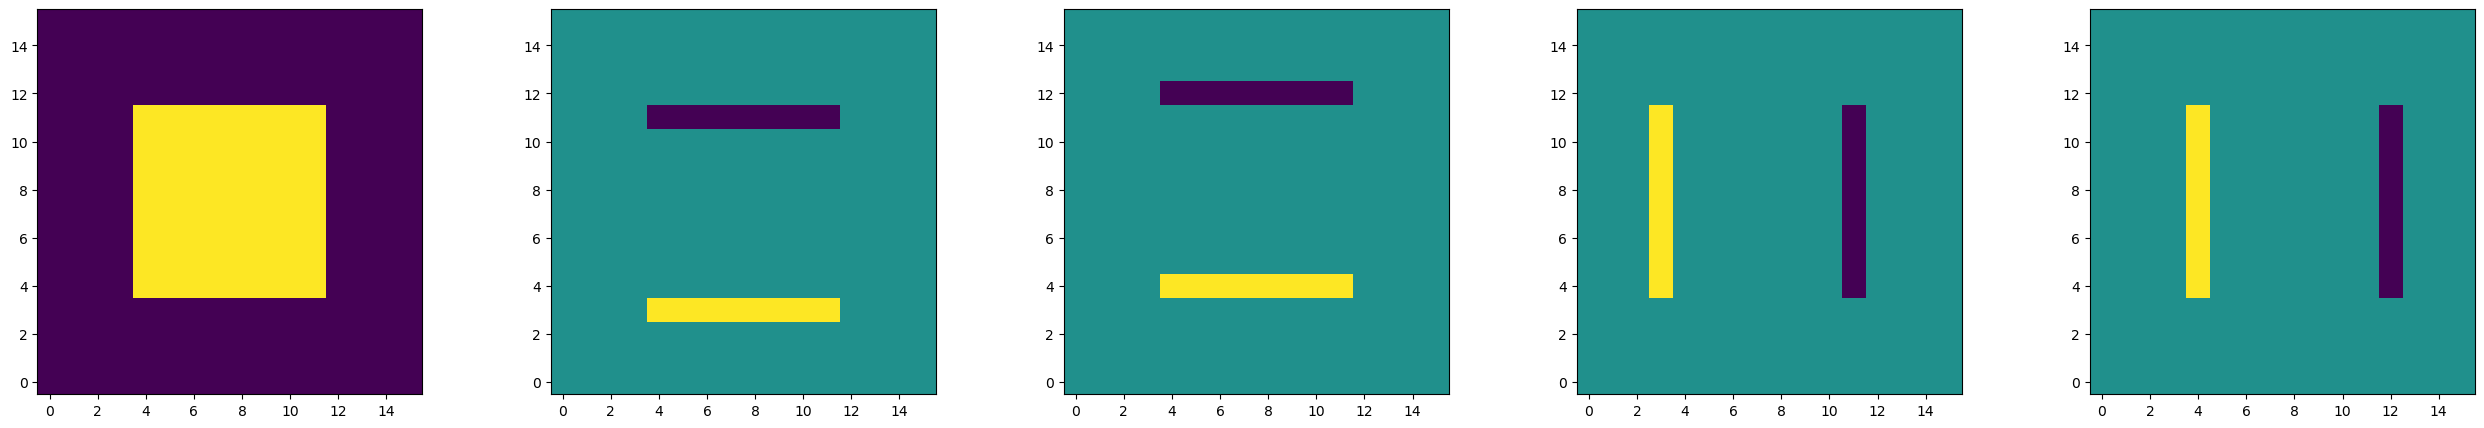

In [5]:
plt.figure(figsize=(32, 5))
plt.subplot(1, 5, 1)
plt.imshow(image[0, 0].cpu().numpy(), origin="lower")
plt.subplot(1, 5, 2)
plt.imshow(dy_r[0, 0].cpu().numpy(), origin="lower")
plt.subplot(1, 5, 3)
plt.imshow(dy_l[0, 0].cpu().numpy(), origin="lower")
plt.subplot(1, 5, 4)
plt.imshow(dx_r[0, 0].cpu().numpy(), origin="lower")
plt.subplot(1, 5, 5)
plt.imshow(dx_l[0, 0].cpu().numpy(), origin="lower")

Text(0.5, 1.0, 'Linear')

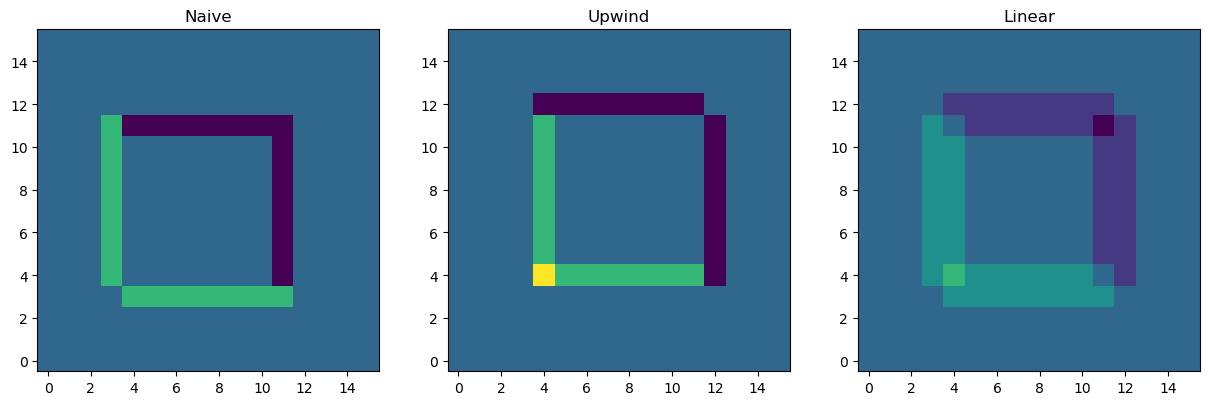

In [6]:
posi_vx = torch.ones_like(image).cuda()
posi_vy = torch.ones_like(image).cuda()
adv = Advection(right_diff)
adv_linear = Advection(
    FiniteDifference(filter_1d=np.array([-0.5, 0.0, 0.5], dtype=np.float32))
)
adv_upwind = AdvectionUpwind(left_diff, right_diff)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(
    adv(image, torch.cat([posi_vx, posi_vy], dim=1)).cpu().numpy()[0, 0],
    origin="lower",
    vmin=-1,
    vmax=2,
)
plt.title("Naive")
plt.subplot(1, 3, 2)
plt.imshow(
    adv_upwind(image, torch.cat([posi_vx, posi_vy], dim=1))
    .cpu()
    .numpy()[0, 0],
    origin="lower",
    vmin=-1,
    vmax=2,
)
plt.title("Upwind")
plt.subplot(1, 3, 3)
plt.imshow(
    adv_linear(image, torch.cat([posi_vx, posi_vy], dim=1))
    .cpu()
    .numpy()[0, 0],
    origin="lower",
    vmin=-1,
    vmax=2,
)
plt.title("Linear")

In [7]:
ic_t = torch.zeros(1, 1, 32, 32, device="cuda", dtype=torch.float32)
ic_t[0, 0, 4:13, 4:13] = 1.0
ic = torch.cat([ic_t, torch.ones_like(ic_t), torch.ones_like(ic_t)], dim=1)

In [8]:
def adv_eqn(current, adv_n):
    t, v = current[:, 0:1, :, :], current[:, 1:, :, :]
    return torch.cat([-adv_n(t, v), torch.zeros_like(v)], dim=1)


adv_linear_diff = lambda x: adv_eqn(x, adv_linear)
adv_upwind_diff = lambda x: adv_eqn(x, adv_upwind)

rk4_int = RK4()
cdiff = FiniteDifference(
    filter_1d=np.array([-1.0, 0.0, 1.0], dtype=np.float32) * 0.5,
    padding_mode="circular",
)
integrator = Integrator(False, [], rk4_int, [None], "constant", cdiff)
t0 = torch.tensor(0.0, dtype=torch.float32).cuda()
t1 = torch.tensor(range(1, 121), dtype=torch.float32).cuda() * 0.1

seq_linear = integrator(adv_linear_diff, ic, t0, t1)
seq_upwind = integrator(adv_upwind_diff, ic, t0, t1)

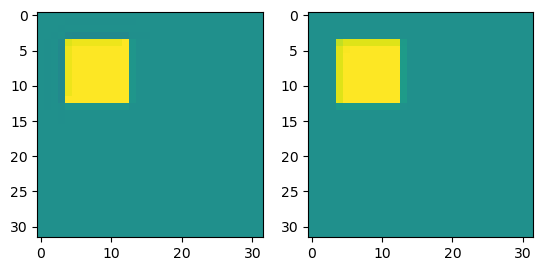

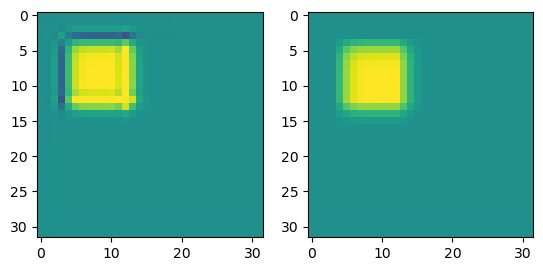

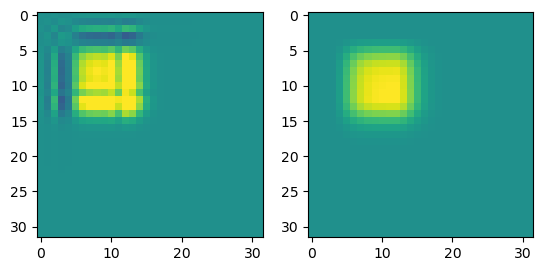

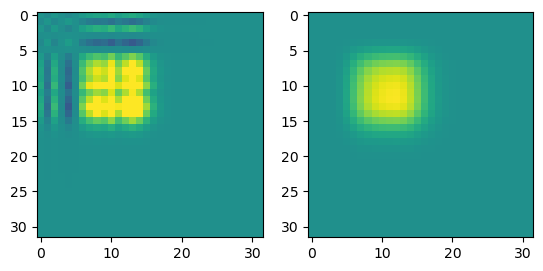

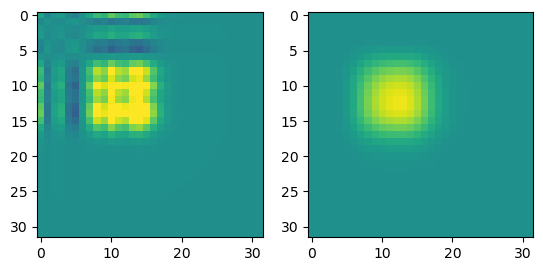

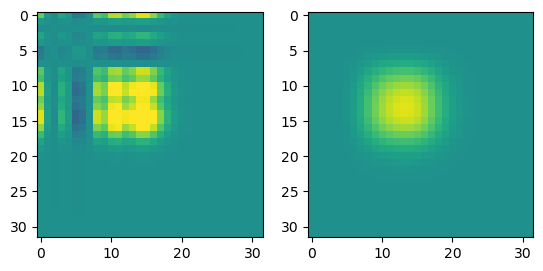

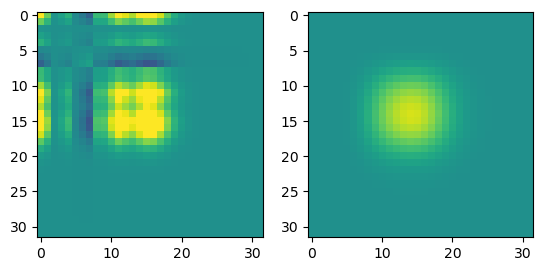

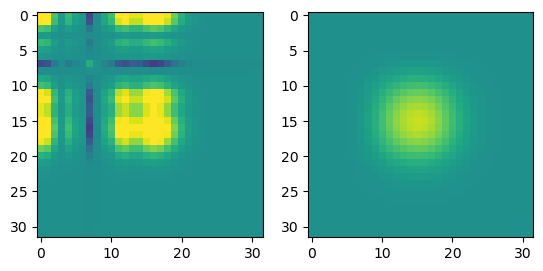

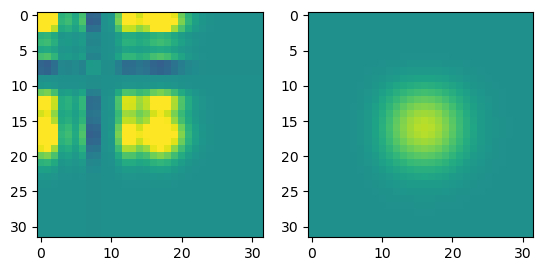

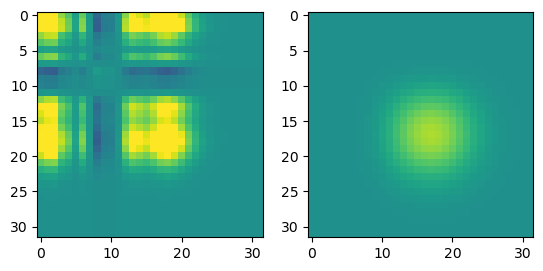

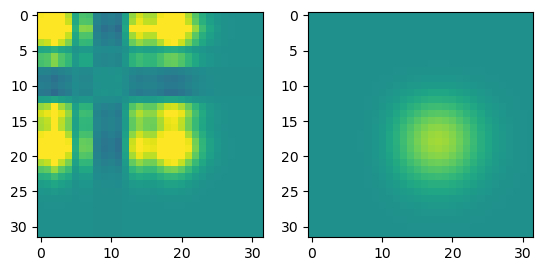

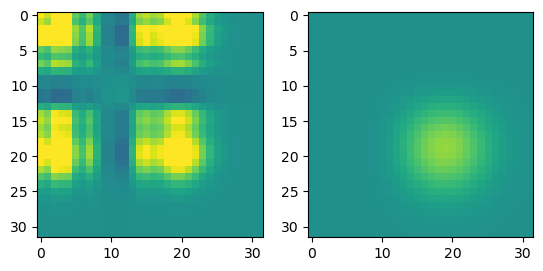

In [9]:
for i in range(12):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(
        seq_linear[i * 10, 0, 0, :, :].detach().cpu().numpy(), vmin=-1, vmax=1
    )
    plt.subplot(1, 2, 2)
    plt.imshow(
        seq_upwind[i * 10, 0, 0, :, :].detach().cpu().numpy(), vmin=-1, vmax=1
    )

### Submodule customization

In [10]:
n_fe_features = 64
unet_em = UNet(
    [64, 64 * 2, 64 * 4, 64 * 8, 64 * 16],
    5,
    n_fe_features,
    up_block_use_concat=[False, True, False, True],
    skip_connection_indices=[2, 0],
)
left_diff = FiniteDifference(
    padding_mode="replicate", right_bottom=False
).cuda()
right_diff = FiniteDifference(padding_mode="replicate").cuda()
# Declare the differentiator first
diff_em = Differentiator(
    3,  # 3 state variables: T, p, mu. We always assume 2 velocity being the last 2 channels
    n_fe_features,  # Number of features returned by the feature extraction network: 128
    [0, 1, 2, 3, 4],  # Channel indices to calculate advection: all channels
    [],  # No diffusion
    unet_em,  # Feature extraction network: unet_em
    "reflect",  # Padding mode: constant padding of zero
    right_diff,  # Finite difference method: replication of image_gradients
    False,  # Disable random gaussian noise during training
).cuda()

In [13]:
summary(diff_em, input_size=(4, 5, 128, 192))

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 47.51 GiB of which 25.94 MiB is free. Process 7242 has 582.00 MiB memory in use. Process 13097 has 45.22 GiB memory in use. Including non-PyTorch memory, this process has 608.00 MiB memory in use. Of the allocated memory 283.22 MiB is allocated by PyTorch, and 16.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [20]:
torch.save(diff_em.state_dict(), "test_advnaive.pt")

In [21]:
for i in range(len(diff_em.list_adv)):
    if diff_em.list_adv[i] is not None:
        diff_em.list_adv[i] = AdvectionUpwind(left_diff, right_diff)
summary(diff_em, input_size=(4, 5, 128, 192))

Layer (type:depth-idx)                             Output Shape              Param #
Differentiator                                     [4, 5, 128, 192]          --
├─UNet: 1-1                                        [4, 64, 128, 192]         --
│    └─Sequential: 2-1                             [4, 64, 128, 192]         --
│    │    └─Conv2d: 3-1                            [4, 64, 128, 192]         2,944
│    │    └─LeakyReLU: 3-2                         [4, 64, 128, 192]         --
│    │    └─Conv2d: 3-3                            [4, 64, 128, 192]         4,160
│    │    └─LeakyReLU: 3-4                         [4, 64, 128, 192]         --
│    └─ModuleList: 2-2                             --                        --
│    │    └─UNetDownBlock: 3-5                     [4, 128, 64, 96]          90,368
│    │    └─UNetDownBlock: 3-6                     [4, 256, 32, 48]          360,960
│    │    └─UNetDownBlock: 3-7                     [4, 512, 16, 24]          1,442,816
│    │    └─U

In [22]:
torch.save(diff_em.state_dict(), "test_advupwind.pt")

In [23]:
diff_em.load_state_dict(torch.load("test_advupwind.pt", weights_only=False))

<All keys matched successfully>

In [25]:
# This one is expected to fail
diff_em.load_state_dict(torch.load("test_advnaive.pt", weights_only=False))

RuntimeError: Error(s) in loading state_dict for Differentiator:
	Missing key(s) in state_dict: "list_adv.0.ldiff.dy_filter", "list_adv.0.ldiff.dx_filter", "list_adv.0.rdiff.dy_filter", "list_adv.0.rdiff.dx_filter", "list_adv.1.ldiff.dy_filter", "list_adv.1.ldiff.dx_filter", "list_adv.1.rdiff.dy_filter", "list_adv.1.rdiff.dx_filter", "list_adv.2.ldiff.dy_filter", "list_adv.2.ldiff.dx_filter", "list_adv.2.rdiff.dy_filter", "list_adv.2.rdiff.dx_filter", "list_adv.3.ldiff.dy_filter", "list_adv.3.ldiff.dx_filter", "list_adv.3.rdiff.dy_filter", "list_adv.3.rdiff.dx_filter", "list_adv.4.ldiff.dy_filter", "list_adv.4.ldiff.dx_filter", "list_adv.4.rdiff.dy_filter", "list_adv.4.rdiff.dx_filter". 
	Unexpected key(s) in state_dict: "list_adv.0.cdiff.dy_filter", "list_adv.0.cdiff.dx_filter", "list_adv.1.cdiff.dy_filter", "list_adv.1.cdiff.dx_filter", "list_adv.2.cdiff.dy_filter", "list_adv.2.cdiff.dx_filter", "list_adv.3.cdiff.dy_filter", "list_adv.3.cdiff.dx_filter", "list_adv.4.cdiff.dy_filter", "list_adv.4.cdiff.dx_filter". 